In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import random
import mplfinance as mpl
import seaborn as sns
from tqdm.notebook import tqdm, trange

In [8]:
#structure to store events in the replay buffer
Transition = namedtuple('Transition',            
                       ('state', 'action', 'next_state', 'reward'))


 #replay buffer with fixed max capacity
class ReplayMemory(object):                    

    def __init__(self,capacity):
        self.memory=deque([],maxlen=capacity)
    
    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
        
#helper function for decreasing exploration rate.
def dec_exp(n, n_, e_min=.1, e_max=.8):
    return max(e_min,e_max*(1- n/n_))

#agent class
class billyboy:                                 
    def __init__(self, money=0, epsilon=0):
        #0=do-nothing, 1=long, 2=short
        self.position=0
        self.entry_price=None
        self.money=money
        self.epsilon=epsilon

    #epsilon-greedy policy
    def act(self,state,policy):
        if np.random.random() > self.epsilon:
            action=int(torch.argmax(policy(state)))
        else:
            action=np.random.choice([0,1,2])
        return action


def compute_rews(entry_price,last_price,short:bool):
    key={True:-1, False:1}
    rew=key[short]*int(last_price<entry_price)
    return rew

def compute_perf(entry_price,last_price,short:bool):
    key={True:-1, False:1}
    res=key[short]*((last_price - entry_price)/entry_price)
    return res

class simple_MLP(nn.Module): # test a CNN then other cool stuff, then try smth like muzero
    def __init__(self):
        super(simple_MLP,self).__init__()
        self.fc=nn.Sequential(
            nn.Linear(3*50*5,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,3)
        )
    def forward(self,x):
        x=x.view(-1,3*50*5)
        x=self.fc(x)
        return x

class simple_convnet(nn.Module):
    def __init__(self):
        super(simple_convnet,self).__init__()
        self.conv1=nn.Conv2d(3,16,(5,5))
        self.conv2=nn.Conv2d(16,16,(5,1))
        self.fc1=nn.Linear(672,3)
    
    def forward(self, x):
        x=self.conv1(x)
        x=F.relu(x)
        x=self.conv2(x)
        x=F.relu(x)
        x=torch.flatten(x,1)
        x=self.fc1(x)
        x=F.relu(x)

        return x

#test cumulative return function     
def test_cumul(policy,data):                    
    policy.eval()
    N=50
    agent=billyboy(money=1000,epsilon=0.3)
    mask=np.zeros(data.shape[0],dtype=bool)
    in_pos=False
    pf=[agent.money]
    trades=[]
    actions=[]
    print(data.shape[0])
    for i in tqdm(range(N,data.shape[0]), unit='step', desc='testing'):
        state=torch.zeros(3,N,data.shape[1])
        mask=np.zeros_like(mask)
        mask[i-N:i]=1
        state[agent.position]=data[mask]
        action=int(torch.argmax(policy(state.unsqueeze(0))))
        actions.append(action)
        if (in_pos==False) and (action !=0):
            in_pos=True
            agent.position=action
            agent.entry_price=state[:,-1,3].sum()
        
        if (in_pos==True) and (action==agent.position):
            agent.last_price=state[:,-1,3].sum()

        if (in_pos==True) and (action not in [0, agent.position]):
            in_pos=False
            short=bool(agent.position - 1)
            result=compute_perf(agent.entry_price,state[:,-1,3].sum(),short).numpy()
            agent.money += agent.money*result
            
            trades.append((i,float(agent.entry_price),float(state[:,-1,3].sum()),short,float(result)))
            agent.position=0
        pf.append(agent.money)
    return pf, pd.DataFrame(trades, columns=['idx_data','entry','close','short','res']), actions




In [4]:
#data to be found at https://drive.google.com/drive/u/0/folders/1Eio-9xGLze3RlNCrJn1B3bzAGLxwyDis

data=torch.from_numpy(np.load('data/train_15meth.npy'))
data_test=torch.from_numpy(np.load('data/test_15meth.npy'))

print(data.shape)

torch.Size([77688, 5])


In [6]:
#main training cell, double DQN
mask=np.zeros(data.shape[0],dtype=bool)
memory=ReplayMemory(1000)
t=0
N=50
steps=12000
in_pos=False
agent=billyboy()
policy=simple_MLP() #model choice
target=simple_MLP() #target
target.load_state_dict(policy.state_dict())
target.eval()
criterion=torch.nn.HuberLoss()
optimizer=torch.optim.Adam(policy.parameters(),lr=5e-5)
gamma=.99
batch_size=128
losses=[]
rewards_=[]
results_=[]
times=[]
sa_means=[]
actions_=[]
count=0

for i in tqdm(range(N,steps), unit='step', desc='training'):
    agent.epsilon=dec_exp(i,1e4)
    if i %(steps//10)==0:
        print(agent.epsilon)
        print(f'step {i} / {steps}')
        print('n of pos last block', count)
        print(f'do nothing {round(actions_[-(steps//10):].count(0)/(steps//10),3)},'+ 
                f'long {round(actions_[-(steps//10):].count(1)/(steps//10),3)},'+
                f'short {round(actions_[-(steps//10):].count(2)/(steps//10),3)}')
        count=0
    state=torch.zeros(3,N,data.shape[1])
    mask=np.zeros_like(mask)
    mask[i-N:i]=1
    state[agent.position]=data[mask]
    
    #take action
    action=agent.act(state.unsqueeze(0),policy)
    actions_.append(action)
    if (in_pos==False) and (action !=0):
        time=i
        in_pos=True
        agent.position=action
        agent.entry_price=state[:,-1,3].sum()
    
    if (in_pos==True) and (action==agent.position):
        agent.last_price=state[:,-1,3].sum()

    if (in_pos==True) and (action not in [0, agent.position]):
        in_pos=False
        times.append(i-time)
        short=bool(agent.position - 1)
        reward=compute_rews(agent.entry_price,state[:,-1,3].sum(),short)
        result=compute_perf(agent.entry_price,state[:,-1,3].sum(),short)
        results_.append(result.detach().numpy())
        rewards_.append(reward)
        agent.position=0

        next_state=torch.zeros(3,N,data.shape[1])
        next_mask=np.zeros_like(mask)
        next_mask[t+1:t+N+1]=1
        next_state[agent.position]=data[next_mask]
        memory.push(state,torch.tensor([action]),next_state, torch.tensor([reward]))
        count+=1
    
    else:
        next_state=torch.zeros(3,N,data.shape[1])
        next_mask=np.zeros_like(mask)
        next_mask[t+1:t+N+1]=1
        next_state[agent.position]=data[next_mask]
        memory.push(state, torch.tensor([action]),next_state, torch.tensor([0]))
    
    #-----------udpt------------#
    if len(memory) > batch_size:
            sample=memory.sample(batch_size)
            sample=Transition(*zip(*sample))

            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                                sample.next_state)))
            non_final_new_states = torch.cat([s.unsqueeze(0) for s in sample.next_state
                                                if s is not None])
            states=torch.cat([state.unsqueeze(0)for state in sample.state])
            actions=torch.cat(sample.action)  
            rewards=torch.cat(sample.reward)
            s_a_vals=policy(states).gather(1,actions.unsqueeze(0))
            
            new_state_vals=torch.zeros(batch_size)
        
            new_state_vals[non_final_mask]=target(non_final_new_states).max(1)[0]
            sa_means.append(s_a_vals.mean().detach().numpy())
            
            expected=new_state_vals*gamma+rewards
            loss=criterion(s_a_vals,expected.unsqueeze(0))
            
            optimizer.zero_grad()
            loss.backward()
            for param in policy.parameters():
                param.grad.data.clamp_(-1, 1)
            losses.append(loss.detach().numpy())
            optimizer.step()

    if i%800==0:  #update target
            target.load_state_dict(policy.state_dict())
               
    t+=1

training:   0%|          | 0/11950 [00:00<?, ?step/s]

0.7040000000000001
step 1200 / 12000
n of pos last block 271
do nothing 0.291,long 0.37,short 0.297
0.6080000000000001
step 2400 / 12000
n of pos last block 273
do nothing 0.318,long 0.318,short 0.365
0.512
step 3600 / 12000
n of pos last block 261
do nothing 0.327,long 0.362,short 0.311
0.41600000000000004
step 4800 / 12000
n of pos last block 254
do nothing 0.329,long 0.305,short 0.366
0.32000000000000006
step 6000 / 12000
n of pos last block 267
do nothing 0.296,long 0.316,short 0.388
0.22400000000000003
step 7200 / 12000
n of pos last block 268
do nothing 0.268,long 0.304,short 0.428
0.12800000000000003
step 8400 / 12000
n of pos last block 169
do nothing 0.312,long 0.162,short 0.527
0.1
step 9600 / 12000
n of pos last block 205
do nothing 0.29,long 0.38,short 0.33
0.1
step 10800 / 12000
n of pos last block 161
do nothing 0.432,long 0.2,short 0.368


8633


testing:   0%|          | 0/8583 [00:00<?, ?step/s]

mean perf training -4.5776746e-05
# of pos training 2431
# of pos test 1170


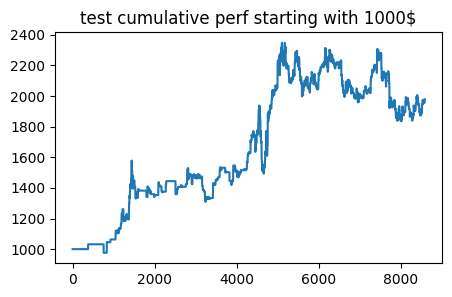

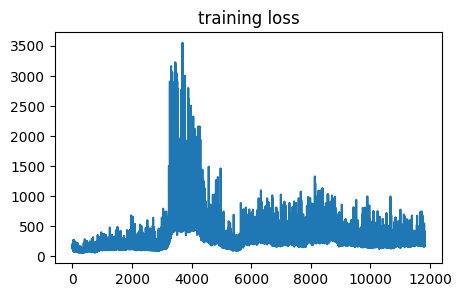

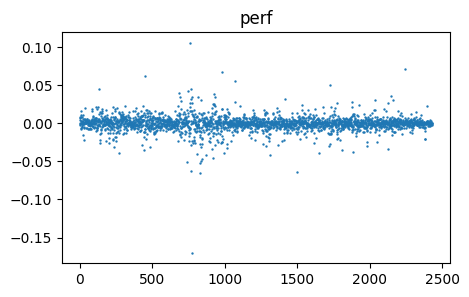

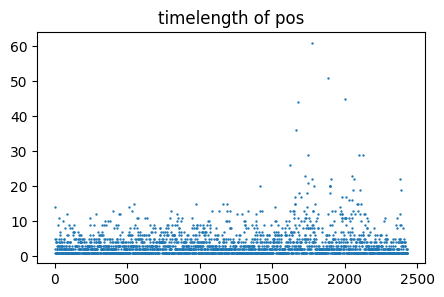

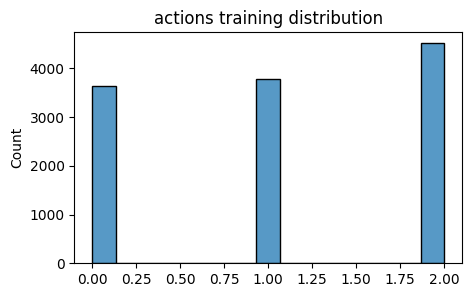

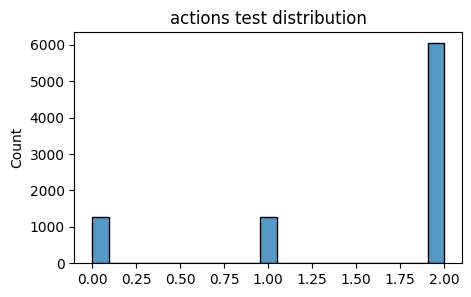

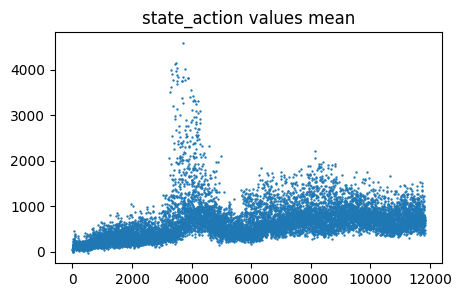

In [10]:
plt.style.use('default')  
matplotlib.rcParams['figure.figsize'] = (5, 3)      
pf, trades,actions_test=test_cumul(policy,data_test)
plt.title('test cumulative perf starting with 1000$')
plt.plot(range(len(pf)),pf)
plt.figure()
plt.title('training loss')
plt.plot(range(len(losses)),losses)
plt.figure()
plt.title('perf')
plt.scatter(range(len(results_)),results_, s=.5)
plt.figure()
plt.title('timelength of pos')
plt.scatter(range(len(times)),times, s=.5)
plt.figure()
plt.title('actions training distribution')
sns.histplot(actions_)
plt.figure()
plt.title('actions test distribution')
sns.histplot(actions_test)
plt.figure()
plt.title('state_action values mean')
plt.scatter(range(len(sa_means)),sa_means, s=.5)

print('mean perf training',np.mean(results_))
print('# of pos training', len(results_))
print('# of pos test', len(trades))





/home/tcastigl/crypto/RL_trading/RL_trading_env/lib/python3.8/site-packages/mplfinance/_arg_validators.py:36: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


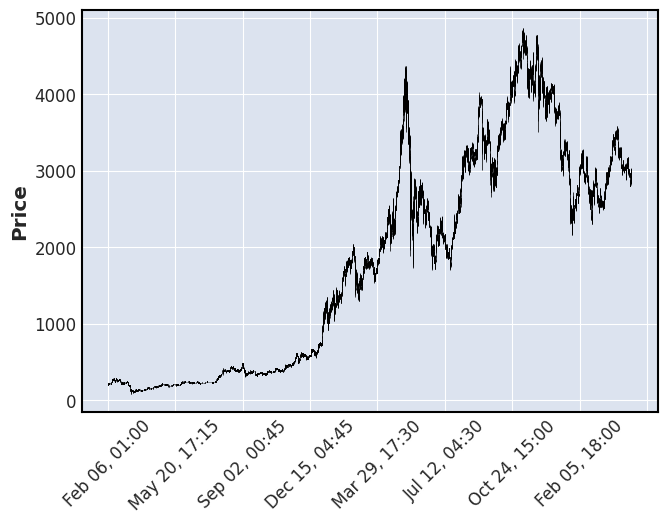

/home/tcastigl/crypto/RL_trading/RL_trading_env/lib/python3.8/site-packages/mplfinance/_arg_validators.py:36: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


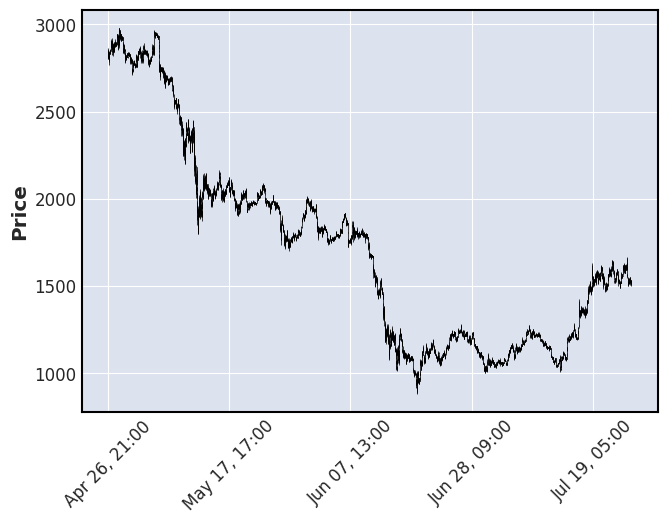

In [13]:
train_full=pd.read_pickle('data/train_full.pkl')
test_full=pd.read_pickle('data/test_full.pkl')
mpl.plot(train_full)
mpl.plot(test_full)
